# Non-standard problems in feature engineering

## December 2018

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
import random

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import power_transform

In [4]:
%matplotlib inline

In [5]:
sns.set_context('talk')
sns.set_style('ticks')
plt.rcParams['figure.figsize'] = (12, 6)

# What are non-standard problems?

A | B | C
- | - | -
![dorafeev](figures/dorafeev.png) | ![dybov](figures/dybov.png) | ![loney](figures/loney.png)

<center><h3>They are no canned solutions</h3></center>


# The problems

### Distributions and transformations
### Missing Values
### Correlations
 

# Problem 1



<img src=figures/distributions.png width="900">

Here is a general purpose function to plot histograms.

In [6]:
def plot_histogram(data_df, feature_label, nb_bins=10):

    plt.hist(data_df[feature_label], 
             bins=nb_bins, 
             color='black',
             edgecolor='white',
             linewidth=1.2)

    plt.xlabel(feature_label)
    plt.title('Distribution of ' + 
              feature_label + 
              ' (bins = ' + str(nb_bins) + ')')

First, import the data, remove redundant features and missing rows.

In [7]:
churn_raw_df = pd.read_excel('data/WA_Fn-UseC_-Telco-Customer-Churn.xlsx', 
                             na_values=' ')

churn_data_df = churn_raw_df.drop(columns=['customerID']).dropna()

print(churn_data_df.shape)

(7032, 20)


Split the data into train and test

In [8]:
churn_features = churn_data_df.drop(columns=['Churn'])
churn_labels = churn_data_df['Churn']


X_train, X_test, y_train, y_test = train_test_split(churn_features, 
                                                    churn_labels, 
                                                    test_size=0.2, 
                                                    random_state=20130810)

### Now, let us plot the histogram with varying number of bins

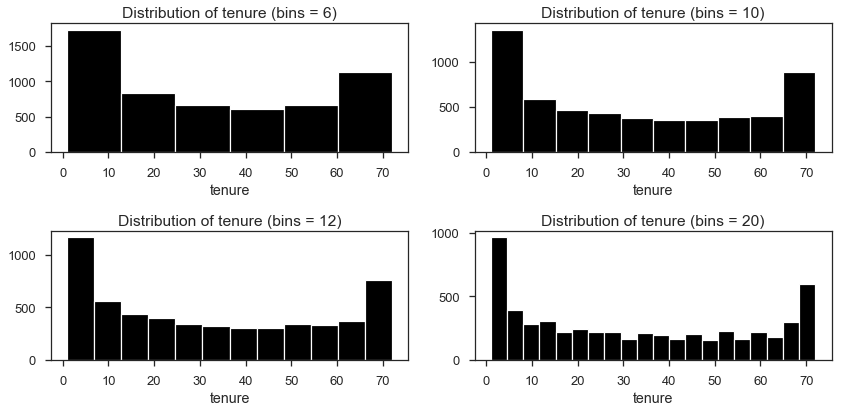

In [9]:
for i, bins in enumerate([6, 10, 12, 20]):
    plot_position = 220+i+1
    plt.subplot(plot_position)
    plot_histogram(data_df=X_train, 
                   feature_label='tenure',
                   nb_bins=bins)
    
plt.tight_layout()

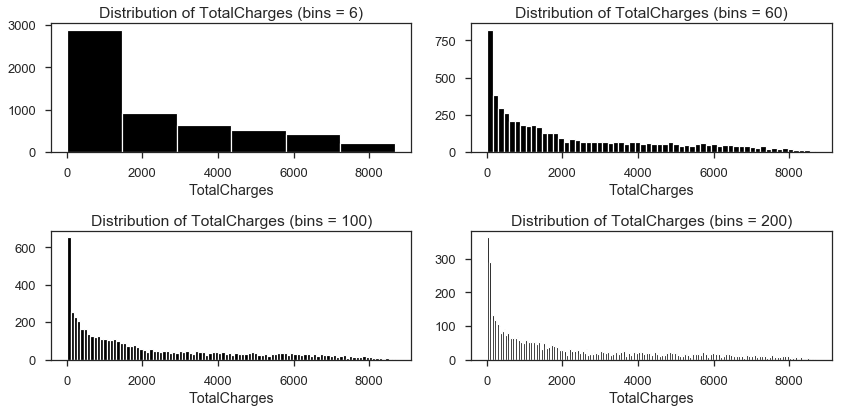

In [10]:
for i, bins in enumerate([6, 60, 100, 200]):
    plot_position = 220+i+1
    plt.subplot(plot_position)

    plot_histogram(data_df=X_train,
                   feature_label='TotalCharges', 
                   nb_bins=bins)
    
plt.tight_layout()

### CDF's solve this problem by taking key decisions away from the analyst

Here is a little function that puts together the scaffolding required.

In [11]:
def plot_cdf(data_df, feature_label):

    x = np.sort(data_df[feature_label])
    y = np.linspace(0, 1, len(x), endpoint=False)

    plt.plot(x, y, color='black')
    
    for q in [0.25, 0.5, 0.75]:
        plt.axvline(x=np.quantile(x, q),
                    alpha=0.8, 
                    linewidth=1.2)

        plt.axhline(y=q, 
                    alpha=0.8, 
                    linewidth=1.2)

    plt.xlabel(feature_label)
    plt.ylabel('F(x)')
    plt.title('CDF of ' + feature_label)

### Lets plot the skewed and non-skewed cumulative distributions

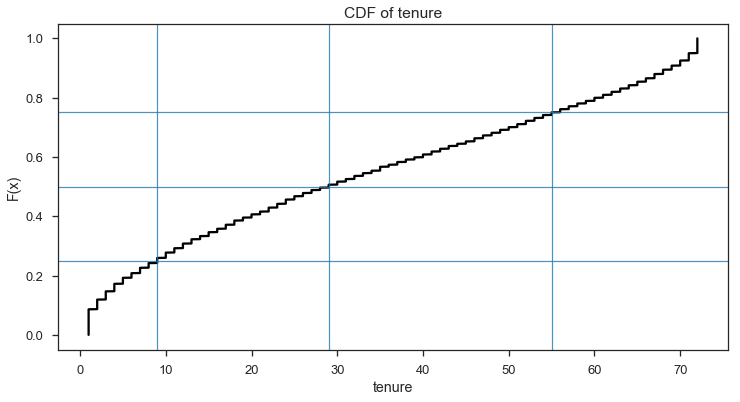

In [12]:
# Non-skewed distribution

plot_cdf(data_df=X_train, feature_label='tenure')

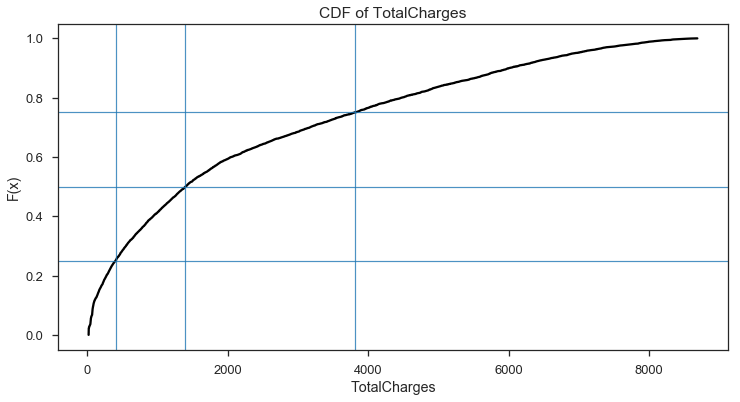

In [13]:
# Skewed distribution

plot_cdf(data_df=X_train, feature_label='TotalCharges')

### We can turbo charge the CDF by overlaying a normal distribution

Here is a helper function that superimposes a normal CDF on the data CDF

In [14]:
def plot_cdf_and_normal(data_df, feature_label):
    x = np.sort(data_df[feature_label])
    
    y = np.linspace(0, 1, len(x), endpoint=False)
    y_norm = ss.norm.cdf(x, np.mean(x), np.std(x))

    plt.plot(x, y, label='data')
    plt.plot(x, y_norm, label='normal distribution')
    
    plt.xlabel(feature_label)
    plt.legend()

### Lets plot the skewed cumulative distribution... again

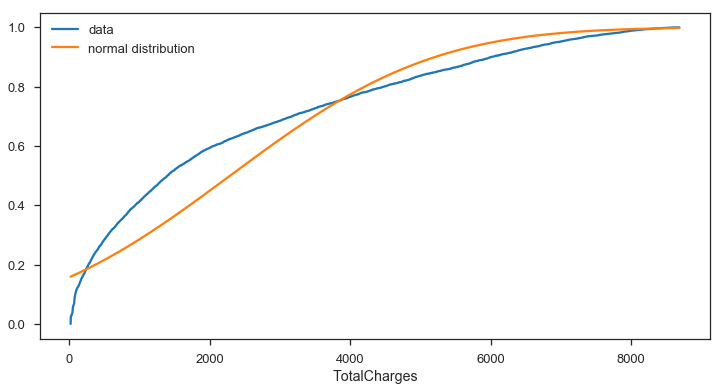

In [15]:
plot_cdf_and_normal(data_df=X_train,
                    feature_label='TotalCharges')

### What to do when the features have a skewed distribution?



In [16]:
# Apply Yeo - Johnson transformation

X_train['TotalCharges_YJ'] = power_transform(X_train['TotalCharges'].values.reshape(-1,1))


Lets see how things work out...

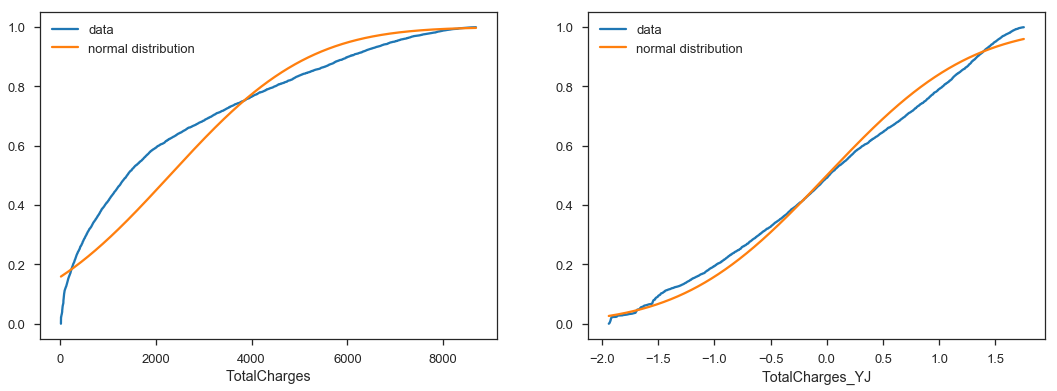

In [17]:
plt.figure(figsize=(18, 6))

plt.subplot(121)
plot_cdf_and_normal(data_df=X_train, feature_label='TotalCharges')


plt.subplot(122)
plot_cdf_and_normal(data_df=X_train, feature_label='TotalCharges_YJ')

# Problem 2

<img src=figures/missing.jpg width="900">

First step is to see how deep the rabbit hole is...

In [18]:
def compute_missing_value_counts(data_df):
    
    counts = data_df.isnull().sum().sort_values(ascending=False)
    
    return counts[counts != 0]

In [19]:
def compute_missing_value_perc(data_df):
    
    counts = data_df.isnull().sum().sort_values(ascending=False)
    
    non_zero_counts = counts[counts != 0]
    
    n_samples = data_df.shape[0]
    
    return non_zero_counts * 100/n_samples

In [20]:
def cols_with_missings(data_df):

    return [col for col in data_df.columns if data_df[col].isnull().any()]

Always ask the data source - how did you capture missing values?

In [21]:
churn_raw_df = pd.read_excel('data/WA_Fn-UseC_-Telco-Customer-Churn.xlsx', 
                             na_values=' ')

In [22]:
compute_missing_value_counts(churn_raw_df)

TotalCharges    11
dtype: int64

In [23]:
compute_missing_value_perc(churn_raw_df)

TotalCharges    0.156183
dtype: float64

In [24]:
cols_with_missings(churn_raw_df)

['TotalCharges']

Lets make the problem a bit more complicated

In [25]:
properties_raw_df = pd.read_csv('data/big/properties_2016.csv')

In [26]:
cols_with_missings(properties_raw_df)[0:5] # show only first five in the list

['airconditioningtypeid',
 'architecturalstyletypeid',
 'basementsqft',
 'bathroomcnt',
 'bedroomcnt']

In [27]:
compute_missing_value_perc(properties_raw_df)[0:5] # show 5 worst offenders

storytypeid                 99.945599
basementsqft                99.945465
yardbuildingsqft26          99.911330
fireplaceflag               99.827048
architecturalstyletypeid    99.796966
dtype: float64

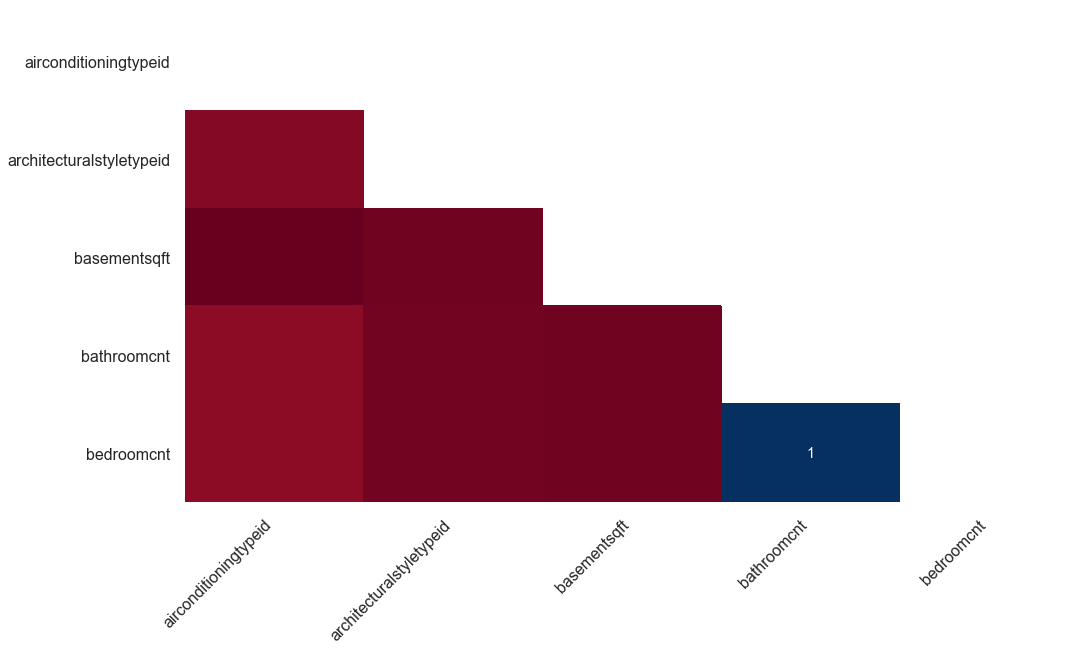

In [35]:
top_five_missing_columns = cols_with_missings(properties_raw_df)[0:5]
missingno.heatmap(properties_raw_df[top_five_missing_columns], figsize=(16,9))

## What to do with missing data?

Three common strategies

- Drop if okay
- Impute if not okay
- Add flag variable for missing values

### Add flag variable when missing

In [30]:
def add_variable_for_missings(data_df):
    
    df = data_df.copy()
    
    for col in df.columns:
        df[col+'_missing'] = df[col].isnull()
        
    return df

In [31]:
properties_missing_cols_df = add_variable_for_missings(properties_raw_df)

In [32]:
properties_raw_df.columns[-10:-1]

Index(['numberofstories', 'fireplaceflag', 'structuretaxvaluedollarcnt',
       'taxvaluedollarcnt', 'assessmentyear', 'landtaxvaluedollarcnt',
       'taxamount', 'taxdelinquencyflag', 'taxdelinquencyyear'],
      dtype='object')

In [33]:
properties_missing_cols_df.columns[-10:-1]

Index(['numberofstories_missing', 'fireplaceflag_missing',
       'structuretaxvaluedollarcnt_missing', 'taxvaluedollarcnt_missing',
       'assessmentyear_missing', 'landtaxvaluedollarcnt_missing',
       'taxamount_missing', 'taxdelinquencyflag_missing',
       'taxdelinquencyyear_missing'],
      dtype='object')

# Problem 3

<img src=figures/correlations.jpg width="900">

## Correlations can be helpful in sense checking models

### (here we are concerned with correlation between features and target; not collinearity)

Here is a function that computes the correlation

In [46]:
def compute_correlations(X_train_df, y_train_df, label_col_str):
    '''
    Compute correlations between all features, select the column corresponding 
    to the label, sort values in descending order and drop the entry for the 
    label (correlation with itself)

    '''
    data_df = pd.concat([X_train, y_train_df], axis=1)
    
    correlations_with_target = data_df.corr()[label_col_str].sort_values(ascending=False)[1:]
    
    corr_df = correlations_with_target.to_frame()
    
    corr_df.index.name = 'feature'
    corr_df.reset_index(inplace=True)
    
    return corr_df

In [63]:
def plot_correlations(correlation_df, feature_str, label_str):
    g = sns.PairGrid(correlation_df, x_vars=label_str, y_vars=feature_str,
                     size=6, aspect=1.1)
    g.map(sns.stripplot, palette="viridis",
          size=6, orient='h', linewidth=1, edgecolor="white")


Lets run these through some data...

In [44]:
bank_raw_df = pd.read_csv('data/bank-full.csv', delimiter=';')

bank_features = bank_raw_df.drop(columns=['y'])
bank_features_dummified = pd.get_dummies(bank_features, dummy_na=False)

bank_labels = bank_raw_df['y']

In [47]:
X_train, X_test, y_train, y_test = train_test_split(bank_features_dummified,
                                                    bank_labels, 
                                                    test_size=0.2, 
                                                    random_state=20130810)

y_train_df = pd.DataFrame(y_train.apply(lambda x: int(x == 'yes')), 
                          columns=['y'])

In [69]:
corr_df = compute_correlations(X_train, y_train_df, 'y')

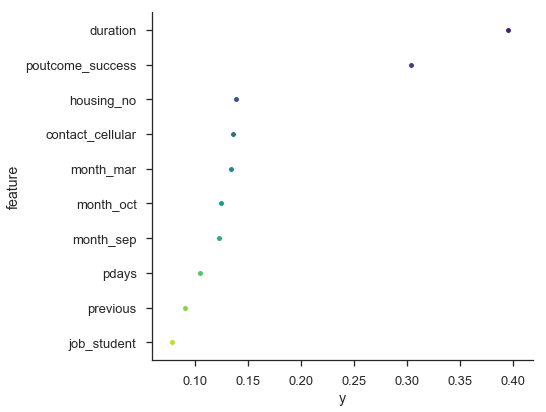

In [70]:
plot_correlations(corr_df.head(10), feature_str='feature', label_str='y')

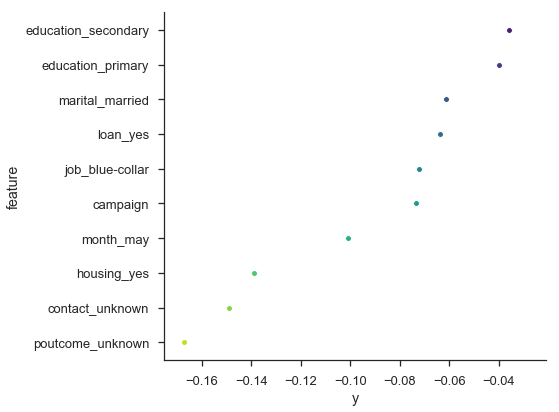

In [71]:
plot_correlations(corr_df.tail(10), feature_str='feature', label_str='y')

![thankyou](figures/thankyou.jpg)